In [1]:
import pdb
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
import pdb

%matplotlib inline

In [2]:
'''Data loading'''
f_names_national = [
    '2012 Conso Prod.csv',
    '2013 Conso Prod.csv',
    '2014 Conso Prod.csv',
    '2015 Conso Prod.csv'
]

datas = []
data_news = []
for f_name in f_names_national:
#     print(f_name)
    data = pd.read_csv('data/'+ f_name, delimiter='\t', encoding = "ISO-8859-1")
    pd.set_option('max_columns', 100)
    headers = list(data)
    data = data[data.Consommation.notnull()]
    data = data[data.Date.notnull()]
    data['timestamp'] = [str(d) + ' ' + str(t) for d, t in zip(data['Date'].values, data['Heures'].values)]
    data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M')
    datas.append(data)

data_final = pd.concat(datas).reset_index()


/home/benlet/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18,19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/benlet/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Sorting values : le premier élement du data set est le plus récent : 
# y(t), y(t-1) etc... 
data_final = data_final.sort_values(by=['Date','Heures'], ascending=[False,False])

'''tau : paramètre de périodicité'''
tau = 48 # 48 : on considère une corrélation de 24h. On pourrait prendre tau = 1 an 
            # afin de correler les données avec les données de l'année passée

def data_labels(dataframe=data_final, field='Consommation', tau = tau):
    X = dataframe[field].values
    X_ = np.stack([np.roll(X,i) for i in range(49)], axis=1)

    labels = X_[:,:1]
    data = X_[:,1:]
    return data, labels


In [12]:
# Creating the training set and the crossvalidation set.
# two years of training, 1 year for cv 
n_samples = data_final.Consommation.values.shape[0]
data_train, labels_train = data_labels(dataframe = data_final[data_final['Date'] <= '2014-12-31'])
data_test, labels_test = data_labels(dataframe = data_final[data_final['Date'] > '2014-12-31'])

# ANN 

In [5]:
import pandas
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [6]:
# fix random seed for reproducibility
np.random.seed(7)

In [37]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(20, input_dim=tau, activation='relu'))
model.add(Dense(20, input_dim=tau, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(data_train, labels_train, nb_epoch=20, batch_size=100, verbose=2)

Epoch 1/20
1s - loss: 15639292.0770
Epoch 2/20
0s - loss: 4643059.1276
Epoch 3/20
0s - loss: 3281113.8204
Epoch 4/20
0s - loss: 2535023.7919
Epoch 5/20
0s - loss: 2191986.6283
Epoch 6/20
0s - loss: 1969982.7332
Epoch 7/20
0s - loss: 1797314.6274
Epoch 8/20
0s - loss: 1614132.3688
Epoch 9/20
0s - loss: 1490352.5375
Epoch 10/20
0s - loss: 1415672.8604
Epoch 11/20
0s - loss: 1264457.5399
Epoch 12/20
0s - loss: 1206818.9669
Epoch 13/20
0s - loss: 1209437.9346
Epoch 14/20
0s - loss: 1136202.2432
Epoch 15/20
0s - loss: 1110528.0649
Epoch 16/20
0s - loss: 1092440.6816
Epoch 17/20
0s - loss: 1003196.1289
Epoch 18/20
0s - loss: 970039.5867
Epoch 19/20
0s - loss: 1037035.1143
Epoch 20/20
0s - loss: 999147.8765


In [38]:
# Estimate model performance
trainScore = model.evaluate(data_train, labels_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(data_test, labels_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

Train Score: 808974.55 MSE (899.43 RMSE)
Test Score: 788113.74 MSE (887.76 RMSE)


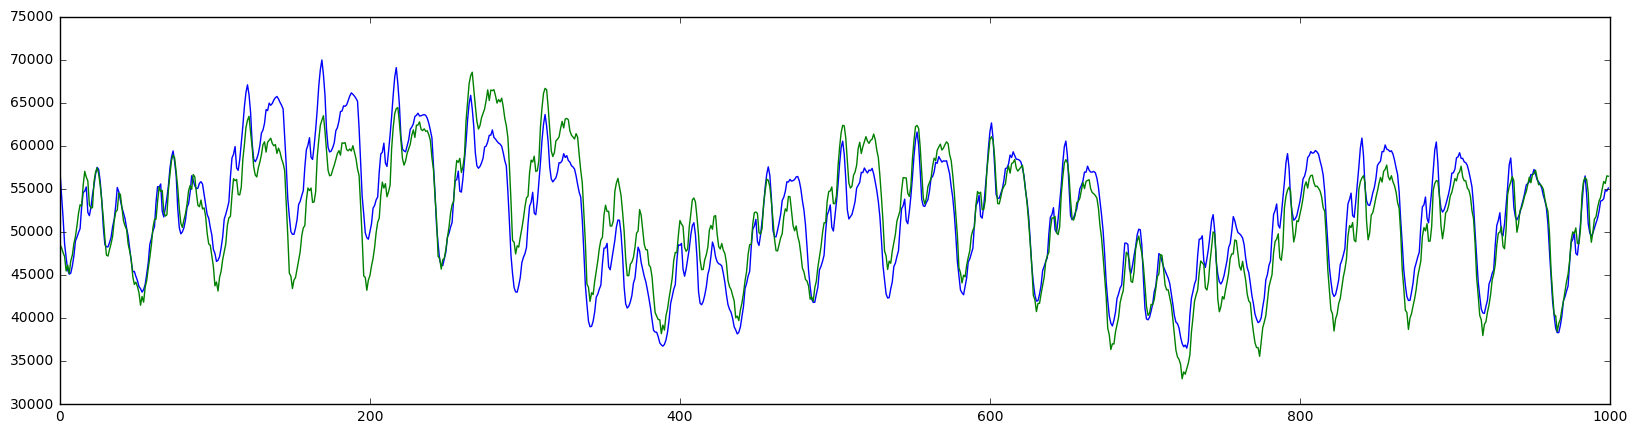

In [39]:
# generate predictions for training
trainPredict = model.predict(data_train)
testPredict = model.predict(data_test)

# shift train predictions for plotting
trainPredictPlot = np.zeros((n_samples,1))
trainPredictPlot[:, :] = np.nan
trainPredictPlot[tau:len(trainPredict), :] = trainPredict[:-tau,:]
# shift test predictions for plotting
testPredictPlot = np.zeros((n_samples,1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(tau)+1:(n_samples), :] = testPredict[:-tau-1,:]
# plot baseline and predictions
sl= slice(20000,21000)
plt.figure(figsize=(20,5))
plt.plot(data_final['Consommation'].values[sl])
plt.plot(trainPredictPlot[sl])
plt.plot(testPredictPlot[sl])
plt.show()